In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import sys

import Corrfunc
from Corrfunc.bases import spline_bases
from Corrfunc.theory.DDsmu import DDsmu
from Corrfunc.theory import xi
from Corrfunc.utils import compute_amps
from Corrfunc.utils import evaluate_xi
from Corrfunc.utils import convert_3d_counts_to_cf
from colossus.cosmology import cosmology

sys.path.insert(0, '/home/aew492/research-summer2020/code')
import read_lognormal
from suave import cosmo_bases, suave
from center_mock import center_mock
import generate_mock_list
import globals

globals.initialize_vals()  # brings in all the default parameters

periodic = globals.periodic
rmin = globals.rmin
rmax = globals.rmax
nbins = globals.nbins
nthreads = globals.nthreads

In [2]:
# load in data
mock_data = read_lognormal.read('/scratch/ksf293/mocks/lognormal/cat_L750_n1e-4_z057_patchy_As2x/cat_L750_n1e-4_z057_patchy_As2x_lognormal_rlz0.bin')
L, _, _, nd, data = mock_data
x, y, z, _, _, _ = data.T

In [3]:
# random set
nr = 2*nd
xs_rand = np.random.uniform(0,L,(3,nr))
xr, yr, zr = xs_rand

In [4]:
# other parameters for suave
ntopbins = 10
r_edges = np.linspace(rmin, rmax, ntopbins+1) 
ncont = 2000
r_fine = np.linspace(rmin, rmax, ncont)

nmubins = 1
mumax = 1.0

### standard estimator

In [5]:
xi_res = xi(L, nthreads, r_edges, x, y, z, output_ravg=True)
r_avg, xi_standard = xi_res['ravg'], xi_res['xi']

### cubic spline basis

In [6]:
# bases
proj_type = 'generalr'
kwargs = {'order': 3}
projfn_c = '/home/aew492/research-summer2020/cubic_spline.dat'
ncomponents_c = 14  # pulled this number from suave's docs
bases = spline_bases(rmin, rmax, projfn_c, ncomponents_c, ncont=2000, **kwargs)

In [7]:
# run the pair counts
dd_res_c, dd_proj_c, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z,
                                  boxsize=L, periodic=periodic, proj_type=proj_type,
                                  ncomponents=ncomponents_c, projfn=projfn_c)
dr_res_c, dr_proj_c, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z,
                                  X2=xr, Y2=yr, Z2=zr,
                                  boxsize=L, periodic=periodic, proj_type=proj_type,
                                  ncomponents=ncomponents_c, projfn=projfn_c)
rr_res_c, rr_proj_c, qq_proj_c = DDsmu(1, nthreads, r_edges, mumax, nmubins,
                                         xr, yr, zr, boxsize=L,
                                         periodic=periodic, proj_type=proj_type,
                                         ncomponents=ncomponents_c, projfn=projfn_c)

In [8]:
amps_c = compute_amps(ncomponents_c, nd, nd, nr, nr, dd_proj_c, dr_proj_c, dr_proj_c, rr_proj_c, qq_proj_c)
xi_proj_c = evaluate_xi(amps_c, r_fine, proj_type, rbins=r_edges, projfn=projfn_c)

### BAO basis

In [9]:
# bases
proj_type = 'generalr'
projfn_b = 'cosmo_basis.dat'
basis_b = cosmo_bases(rmin, rmax, projfn_b, redshift=0.57, bias=2.0)
ncomponents_b = basis_b.shape[1]-1

cosmo_base not provided, defaulting to Planck 2015 cosmology ('planck15')


In [10]:
# run the pair counts
dd_res_b, dd_proj_b, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z,
                                  boxsize=L, periodic=periodic, proj_type=proj_type,
                                  ncomponents=ncomponents_b, projfn=projfn_b)
dr_res_b, dr_proj_b, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z,
                                  X2=xr, Y2=yr, Z2=zr,
                                  boxsize=L, periodic=periodic, proj_type=proj_type,
                                  ncomponents=ncomponents_b, projfn=projfn_b)
rr_res_b, rr_proj_b, qq_proj_b = DDsmu(1, nthreads, r_edges, mumax, nmubins,
                                         xr, yr, zr, boxsize=L,
                                         periodic=periodic, proj_type=proj_type,
                                         ncomponents=ncomponents_b, projfn=projfn_b)

In [11]:
amps_b = compute_amps(ncomponents_b, nd, nd, nr, nr, dd_proj_b, dr_proj_b, dr_proj_b, rr_proj_b, qq_proj_b)
xi_proj_b = evaluate_xi(amps_b, r_fine, proj_type, rbins=r_edges, projfn=projfn_b)

### bao_iterative basis

In [12]:
# basis
proj_type = 'generalr'
projfn_it = os.path.join(f'/scratch/aew492/research-summer2020_output/bases/bao_iterative/tables/final_bases/basis_L750_n1e-4_z057_patchy_As2x_rlz0.dat')
basis_it = np.loadtxt(projfn_it)
ncomponents_it = basis_it.shape[1]-1

In [13]:
# run the pair counts
dd_res_it, dd_proj_it, _ = DDsmu(1, nthreads, r_edges, mumax, nmubins, x, y, z,
                                  boxsize=L, periodic=periodic, proj_type=proj_type,
                                  ncomponents=ncomponents_it, projfn=projfn_it)
dr_res_it, dr_proj_it, _ = DDsmu(0, nthreads, r_edges, mumax, nmubins, x, y, z,
                                  X2=xr, Y2=yr, Z2=zr,
                                  boxsize=L, periodic=periodic, proj_type=proj_type,
                                  ncomponents=ncomponents_it, projfn=projfn_it)
rr_res_it, rr_proj_it, qq_proj_it = DDsmu(1, nthreads, r_edges, mumax, nmubins,
                                         xr, yr, zr, boxsize=L,
                                         periodic=periodic, proj_type=proj_type,
                                         ncomponents=ncomponents_it, projfn=projfn_it)

In [14]:
amps_it = compute_amps(ncomponents_it, nd, nd, nr, nr, dd_proj_it, dr_proj_it, dr_proj_it, rr_proj_it, qq_proj_it)
xi_proj_it = evaluate_xi(amps_it, r_fine, proj_type, rbins=r_edges, projfn=projfn_it)

### plots

Text(0.5, 1.0, 'Basis function from bao_iterative')

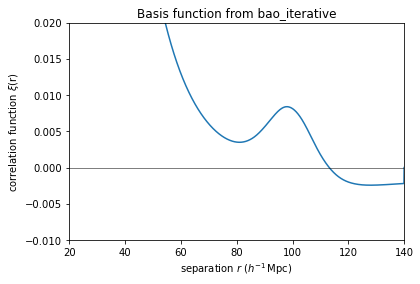

In [15]:
# basis function
fig, ax = plt.subplots()
plt.plot(basis_it[:,0], basis_it[:,1], color='C0', label='final basis')

ax.set_xlim(20, 140)
ax.set_ylim(-.01, 0.02)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title("Basis function from bao_iterative")

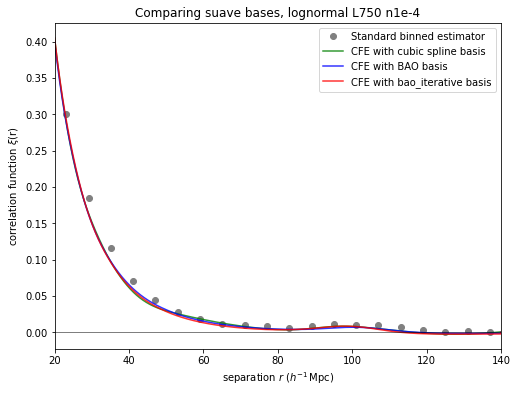

In [22]:
# suave results!
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(r_avg, xi_standard, marker='o', ls='None', color='grey', label='Standard binned estimator')

plt.plot(r_fine, xi_proj_c, color='g', lw=1.5, alpha=0.8, label='CFE with cubic spline basis')
plt.plot(r_fine, xi_proj_b, color='b', lw=1.5, alpha=0.8, label='CFE with BAO basis')
plt.plot(r_fine, xi_proj_it, color='r', lw=1.5, alpha=0.8, label='CFE with bao_iterative basis')

ax.set_xlim(20, 140)
# ax.set_ylim(-.01, 0.05)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(r'Comparing suave bases, lognormal L750 n1e-4')
plt.legend()

In [17]:
results_it = suave(x, y, z, L, projfn_it)

Text(0.5, 1.0, 'Suave with BAO iterative basis, lognormal L750 n1e-4')

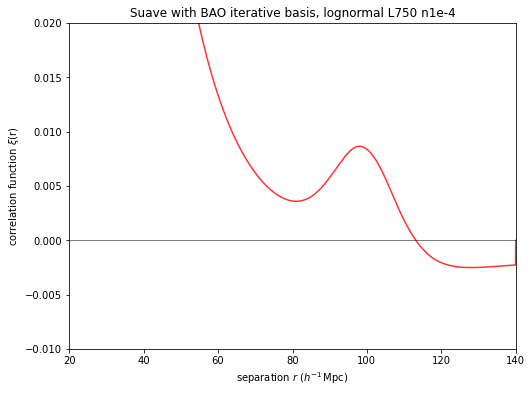

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(results_it[:,0], results_it[:,1], color='r', lw=1.5, alpha=0.8, label='CFE with bao_iterative basis')

ax.set_xlim(20, 140)
ax.set_ylim(-.01, 0.02)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(r'Suave with BAO iterative basis, lognormal L750 n1e-4')

### average of results

In [19]:
nmocks = 300
nbins = 20
r_edges = np.linspace(rmin, rmax, nbins+1) 

#### standard estimator

In [ ]:
xis_standard = np.empty((nmocks, nbins))
for i in range(nmocks):
    # load in data
    mock_data = read_lognormal.read(f'/scratch/ksf293/mocks/lognormal/cat_L750_n1e-4_z057_patchy_As2x/cat_L750_n1e-4_z057_patchy_As2x_lognormal_rlz{i}.bin')
    L, _, _, nd, data = mock_data
    x, y, z, _, _, _ = data.T
    
    xi_res = xi(L, nthreads, r_edges, x, y, z, output_ravg=True)
    r_avg, xi_standard = xi_res['ravg'], xi_res['xi']
    xis_standard[i] = xi_standard
    
avg_xi_st = np.array([r_avg, np.mean(xis_standard, axis=0)]).T

#### suave bao fixed

In [ ]:
path_bao = '/scratch/aew492/research-summer2020_output/lognormal/xi/bao_fixed/L750_n1e-4/'
xis_suave_bao = np.empty((nmocks, 2000))

for i in range(nmocks):
    xi_suave_bao = np.load(os.path.join(path_bao, f'xi_cat_L750_n1e-4_z057_patchy_As2x_lognormal_rlz{i}.npy'), allow_pickle=True)
    xis_suave_bao[i] = xi_suave_bao[:,1]

avg_xi_suave_bao = np.array([xi_suave_bao[:,0], np.mean(xis_suave_bao, axis=0)]).T

#### suave bao iterative

In [20]:
path_bao_it = '/scratch/aew492/research-summer2020_output/lognormal/xi/bao_iterative/L750_n1e-4/'
xis_suave_it = np.empty((nmocks, 2000))

for i in range(nmocks):
    xi_suave_it = np.load(os.path.join(path_bao_it, f'xi_cat_L750_n1e-4_z057_patchy_As2x_lognormal_rlz{i}.npy'), allow_pickle=True)
    xis_suave_it[i] = xi_suave_it[:,1]

avg_xi_suave_it = np.array([xi_suave_it[:,0], np.mean(xis_suave_it, axis=0)]).T

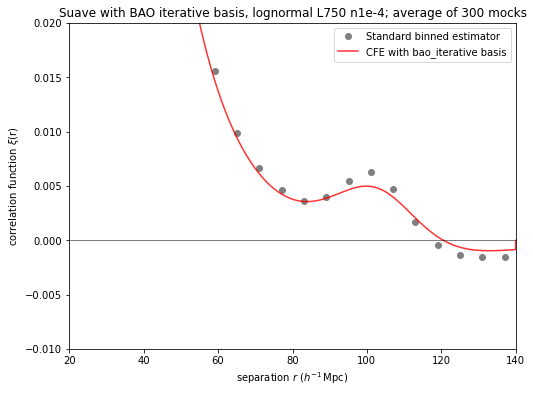

In [21]:
fig, ax = plt.subplots(figsize=(8,6))

plt.plot(avg_xi_st[:,0], avg_xi_st[:,1], marker='o', ls='None', color='grey', label='Standard binned estimator')
plt.plot(avg_xi_suave_bao[:,0], avg_xi_suave_bao[:,1], color='b', lw=1.5, alpha=0.8, label='CFE with fixed bao basis')
plt.plot(avg_xi_suave_it[:,0], avg_xi_suave_it[:,1], color='r', lw=1.5, alpha=0.8, label='CFE with iterative bao basis')

ax.set_xlim(20, 140)
ax.set_ylim(-.01, 0.02)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Suave with BAO iterative basis, lognormal L750 n1e-4; average of {nmocks} mocks')
plt.legend()